# Environment

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
!pip install transformers datasets torch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 33.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 94.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
from datasets import Dataset
import numpy as np
import torch
import torch.nn as nn
from transformers import BertTokenizer, BertPreTrainedModel, BertModel, TrainingArguments, Trainer
from sklearn.metrics import classification_report, precision_score, f1_score

# Dataset Loading

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/IC/data/processed/unified-hate.csv")

In [ ]:
label_columns = df.columns[1:].tolist()

In [ ]:
df["labels"] = df[label_columns].values.tolist()

In [ ]:
dataset = Dataset.from_pandas(df)

# Bert Model Settings

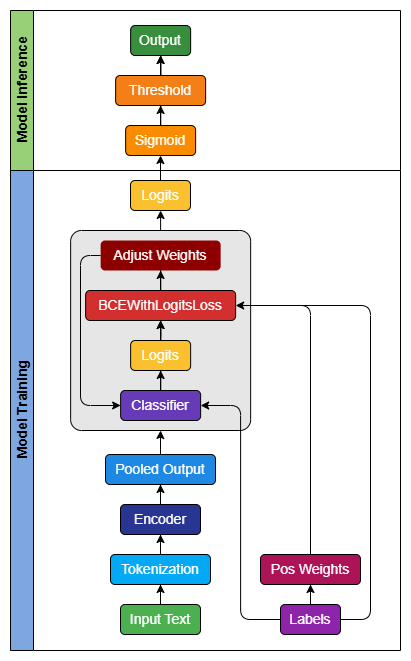

In [ ]:
class BertForMultiTaskClassification(BertPreTrainedModel):
    def __init__(self, config, pos_weights):
        super().__init__(config)
        self.bert = BertModel(config)
        self.classifier = nn.Linear(config.hidden_size, 7)
        self.pos_weights = pos_weights
        self.init_weights()

    def forward(self, input_ids, attention_mask, labels=None):
        outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = outputs[1] # ['CLS']
        logits = self.classifier(pooled_output)

        # Calculada apenas durante o treinamento
        loss = None
        if labels is not None:
            loss_fct = nn.BCEWithLogitsLoss(pos_weight=self.pos_weights)
            loss = loss_fct(logits, labels.float())

        return {"loss": loss, "logits": logits}

In [ ]:
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    logits = torch.sigmoid(torch.tensor(logits))
    preds = (logits > 0.6).numpy().astype(int)

    metrics = {}

    all_task_precision = []
    all_task_recall = []
    all_task_f1 = []

    for task_idx in range(7):
        task_preds = preds[:, task_idx]
        task_labels = labels[:, task_idx]

        report = classification_report(
            task_labels,
            task_preds,
            labels=[0, 1],
            output_dict=True,
            zero_division=0
        )

        metrics[f"{label_columns[task_idx]}_precision"] = report["macro avg"]["precision"]
        metrics[f"{label_columns[task_idx]}_recall"] = report["macro avg"]["recall"]
        metrics[f"{label_columns[task_idx]}_f1"] = report["macro avg"]["f1-score"]
        metrics[f"{label_columns[task_idx]}_support"] = report["1"]["support"]

        all_task_precision.append(report["macro avg"]["precision"])
        all_task_recall.append(report["macro avg"]["recall"])
        all_task_f1.append(report["macro avg"]["f1-score"])

    metrics["macro_avg_precision"] = np.mean(all_task_precision)
    metrics["macro_avg_recall"] = np.mean(all_task_recall)
    metrics["macro_avg_f1"] = np.mean(all_task_f1)

    return metrics

In [ ]:
model_name = "neuralmind/bert-large-portuguese-cased"

In [ ]:
tokenizer = BertTokenizer.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/155 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/648 [00:00<?, ?B/s]

In [ ]:
def tokenize_function(examples):
    tokenized = tokenizer(
        examples["text"],
        padding="max_length",
        truncation=True,
        max_length=256
        )
    tokenized["labels"] = examples["labels"]
    return tokenized

In [ ]:
dataset = dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/15304 [00:00<?, ? examples/s]

In [ ]:
dataset = dataset.train_test_split(test_size=0.3, shuffle=True, seed=20)

In [ ]:
train_labels = np.array(dataset["train"]["labels"])
num_pos = np.sum(train_labels, axis=0)
num_neg = train_labels.shape[0] - num_pos
pos_weights = torch.tensor(num_neg / num_pos)
pos_weights = pos_weights.to(torch.device("cuda"))

In [ ]:
model = BertForMultiTaskClassification.from_pretrained(model_name, pos_weights=pos_weights)

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Some weights of BertForMultiTaskClassification were not initialized from the model checkpoint at neuralmind/bert-large-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


# Model: 70/30



### 3 Epochs

In [ ]:
training_args = TrainingArguments(
    output_dir="/content/drive/MyDrive/IC/models/BertUnifiedHate-Weighted/results",
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    learning_rate=2e-5,
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir="/content/drive/MyDrive/IC/models/BertUnifiedHate-Weighted/logs",
    eval_strategy="epoch",
    save_strategy="epoch",
    report_to="none",
    load_best_model_at_end=True,
    )

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    compute_metrics=compute_metrics,
    processing_class=tokenizer
    )

trainer.train()

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss,Insult Precision,Insult Recall,Insult F1,Insult Support,Obscene Precision,Obscene Recall,Obscene F1,Obscene Support,Ideology Precision,Ideology Recall,Ideology F1,Ideology Support,Lgbtqphobia Precision,Lgbtqphobia Recall,Lgbtqphobia F1,Lgbtqphobia Support,Racism Precision,Racism Recall,Racism F1,Racism Support,Sexism Precision,Sexism Recall,Sexism F1,Sexism Support,Xenophobia Precision,Xenophobia Recall,Xenophobia F1,Xenophobia Support,Macro Avg Precision,Macro Avg Recall,Macro Avg F1
1,No log,0.784635,0.683368,0.687472,0.643137,2914.000000,0.805076,0.809750,0.805837,2594.000000,0.737448,0.832393,0.772172,509.000000,0.622976,0.840577,0.660665,225.000000,0.686250,0.701946,0.693762,70.000000,0.613819,0.790210,0.637982,311.000000,0.667853,0.729908,0.693607,92.000000,0.688113,0.770322,0.701023
2,0.863600,0.598126,0.764777,0.781243,0.768383,2914.000000,0.819652,0.818453,0.803780,2594.000000,0.752163,0.864072,0.791844,509.000000,0.842127,0.877965,0.859024,225.000000,0.679126,0.840491,0.733066,70.000000,0.667248,0.810195,0.708309,311.000000,0.603868,0.866628,0.650856,92.000000,0.732709,0.837007,0.759323
3,0.516800,0.684696,0.760842,0.781048,0.753715,2914.000000,0.830499,0.835668,0.827165,2594.000000,0.762787,0.850916,0.797005,509.000000,0.819053,0.880234,0.846551,225.000000,0.689157,0.862141,0.746747,70.000000,0.687011,0.778260,0.720508,311.000000,0.686427,0.794237,0.727211,92.000000,0.747968,0.826072,0.774129


TrainOutput(global_step=1005, training_loss=0.6881484519189863, metrics={'train_runtime': 2237.0194, 'train_samples_per_second': 14.366, 'train_steps_per_second': 0.449, 'total_flos': 1.4974526120546304e+16, 'train_loss': 0.6881484519189863, 'epoch': 3.0})

In [ ]:
model.save_pretrained("/content/drive/MyDrive/IC/models/BertUnifiedHate-Weighted")
tokenizer.save_pretrained("/content/drive/MyDrive/IC/models/BertUnifiedHate-Weighted")

('/content/drive/MyDrive/IC/models/BertUnifiedHate-Weighted/tokenizer_config.json',
 '/content/drive/MyDrive/IC/models/BertUnifiedHate-Weighted/special_tokens_map.json',
 '/content/drive/MyDrive/IC/models/BertUnifiedHate-Weighted/vocab.txt',
 '/content/drive/MyDrive/IC/models/BertUnifiedHate-Weighted/added_tokens.json')